## Do imports

In [2]:
# MDAnalysis tools
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align, pca,contacts
from MDAnalysis import transformations
# To view the trajs on notebook
import nglview as nv
import pytraj as pt
from ipywidgets import interact, fixed

In [3]:
# Data processing
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
import hdbscan as HDBSCAN               #clustering algorithm

In [4]:
# Plot & System tools
import matplotlib as mpl
import matplotlib.pyplot as plt
from  matplotlib.colors import ListedColormap, NoNorm, BoundaryNorm, CSS4_COLORS
import seaborn as sns

# Remove warnings
import warnings
warnings.filterwarnings('ignore')


#Change working directory to current directory
import os

In [5]:
# Function to see motion along a pca
# Inputs: PC index, frame_i, frame_j , selection
def get_motion(pindex=0, framei=0, framej=100, sel='name CA' ):
    getpc =  mypca.p_components[:, pindex]
    trans =  pcspace[:, pindex]
    projected = np.outer(trans, getpc ) + mypca.mean.flatten()
    
    backbone = U.select_atoms(sel)
    proj = mda.Merge(backbone)
    coordinates = projected.reshape(len(trans), -1, 3)
    proj.load_new(coordinates[ [framei,framej],: ], order="fac")
    
    return proj

In [6]:
%reload_ext watermark
%watermark --iversions
%watermark

pytraj     2.0.5
numpy      1.19.5
matplotlib 3.3.4
MDAnalysis 2.0.0
seaborn    0.11.2
nglview    3.0.3
pandas     1.1.5

2022-11-04T11:34:41+01:00

CPython 3.6.13
IPython 7.16.1

compiler   : GCC 7.5.0
system     : Linux
release    : 4.15.0-194-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 48
interpreter: 64bit


In [7]:
!jupyter-nbextension enable nglview --py --sys-prefix
!jupyter-nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension nglview-js-widgets/extension...
      - Validating: OK
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Set the directory for the simulation

In [8]:
os.chdir('/home/ali/cg_simulations/new_simu1')

#  Before we start, we define
    1. Input  files (finp)
    2. Output files (fout)

In [9]:
finp_ref  = 'system.gro'                  # reference
finp_trj  = 'step7_production.pbc.xtc'    # traj

fout_rms   = 'RMSD.csv'  # rmsd output file
fout_rmf   = 'RMSF.csv'  # rmsf output file
fout_pca   = 'PCA.csv'   # PCA projections
fout_cls   = 'CLUS.csv'  # Cluster output file

# We load
    1. trajectory
    2. reference structure file

In [10]:
U   = mda.Universe(finp_ref, finp_trj)       #Open Traj
ref = mda.Universe(finp_ref)                 #Open ref file 

display(U.trajectory)

<XTCReader step7_production.pbc.xtc with 4384 frames of 8686 atoms>

# Visualize the protein

In [47]:
# Select full protein and domains

full = 'protein'

backbone = "protein and name BB"
BB=U.select_atoms(backbone)

receptor = 'protein and name BB and (resid 40-337)'
rec =U.select_atoms(receptor)

peptide = 'protein and name BB and (resid 367-372)'
pep = U.select_atoms(peptide)

In [52]:
BB.residues.names

[array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1', 'SC2', 'SC3'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array(['BB', 'SC1'], dtype=object),
 array([

## **1. Trajectory Alignment & Visualization**
    - We align the traj (& retain `in memory`) using atom group `receptor`.
    - After alignment, we visualize the md movie with nglview.

In [31]:
# Align traj to reference using atmgroup receptor

align.AlignTraj( U, ref, select=receptor , in_memory=True).run()
'Done Boss'

'Done Boss'

In [32]:
def show_residues_around(view, component_index=0, selection="ligand", radius=3.0):
    js = (
        f"""
        // Get first (and only) loaded component: our protein-ligand system
        var system = this.stage.compList[{component_index}];
        // Store current selection, we will need it laer
        var prevSele = system.selection.string;
        // Set selection to our desired ligand
        system.setSelection("{selection}");
        // Select all atoms within 5A from the ligand
        var around = system.structure.getAtomSetWithinSelection(system.selection, {radius});
        """
        """
        // Extend selection so it includes full residues
        var around_complete = system.structure.getAtomSetWithinGroup(around);
        // Add representation for those atoms
        system.addRepresentation("licorice", {sele: around_complete.toSeleString()});
        // Restore selection to original one; otherwise changes won't be reflected
        system.setSelection(prevSele)
        """
    )
    view._execute_js_code(js)
    

In [33]:
def change_representation(view, representation):
    view.clear()
    view.representations = [
        {"type": representation,
         "params": {"sele":"367-372","color":"red","radiusType":"vdW"}},
        {"type": "cartoon",
         "params": {"sele":"40-337","color":"cyan","radiusType":"vdW","opacity":"0.5"}}
    ]
    view.control.rotate(
    mda.lib.transformations.quaternion_from_euler(
        -np.pi/2, np.pi/3, np.pi/6, 'rzyz').tolist())
    view.camera = 'orthographic'
    

view = nv.show_mdanalysis(U, gui=False)


representations = ["cartoon","backbone", "ball+stick"] #for the peptide
    
interact(change_representation,view=fixed(view), representation=representations) 
#show_residues_around(view,selection="40",radius=6.0)
view

interactive(children=(Dropdown(description='representation', options=('cartoon', 'backbone', 'ball+stick'), va…

NGLWidget(max_frame=4383)

Suggested cutoff distances for different simulations

    For all-atom simulations, cutoff = 4.5 Å
    For coarse-grained simulations, cutoff = 6.0 Å


average contacts = 0.22031412930135552


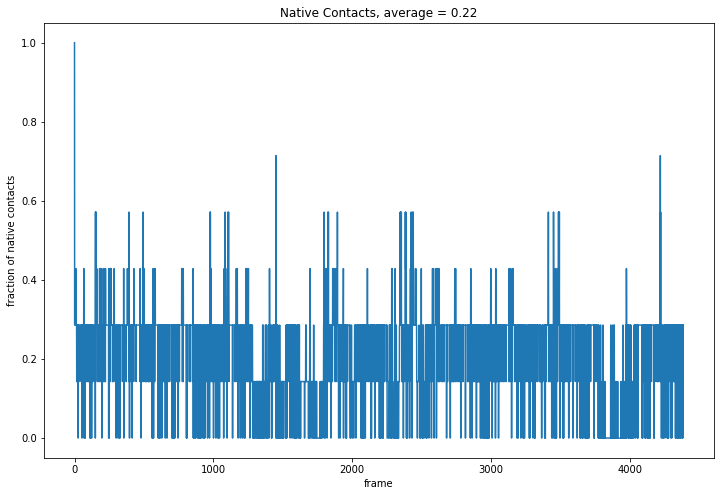

In [34]:
ca1 = contacts.Contacts(U, select=(receptor, peptide),
                        refgroup=(rec, pep), radius=6.0)

ca1.run()

# print number of averave contacts
average_contacts = np.mean(ca1.timeseries[:, 1])
print('average contacts = {}'.format(average_contacts))

# plot time series q(t)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ca1.timeseries[:, 0], ca1.timeseries[:, 1])
ax.set(xlabel='frame', ylabel='fraction of native contacts',
       title='Native Contacts, average = {:.2f}'.format(average_contacts))
fig.show()

In [66]:
from MDAnalysis.core.groups import AtomGroup, Atom

#### **2. RMSD Analysis**

- HOWTO
    1. We first fit the traj using the receptor atoms (group `receptor`).
    2. After fitting, we obtain RMSD for different domains without superimposition (`i.e., re-fitting`)
    3. We create a dataframe (`df_rms`) as the container for RMSD data.
    4. In the dataframe, we use `Time` signature as index (row labels).
        - The trajectory contains snapshots of collected  `@100ps` interval.
        - Hence, we multiply `Time` with 0.001 (i.e., Time/1000.0 to convert in ns)

In [35]:
R = rms.RMSD(U,
             ref,  # reference universe or atomgroup
             select= backbone,  # group to superimpose and calculate RMSD
             groupselections=[receptor,peptide] )  # groups for domain RMSDs
R.run()
display('Done Boss', R.rmsd.shape)

'Done Boss'

(4384, 5)

In [36]:
# Create dataframe of RMSD values
# RMSD routine creates Frame and Time columns + three groups of RMSD calculations
cols = ['Frame','Time', 'full' , 'receptor','peptide', ]
df_rms = pd.DataFrame(R.rmsd, columns=cols)

In [37]:
df_rms.drop('Frame',axis=1,inplace=True)      #Drop Frame column, we retain only Time
df_rms['Time' ] = df_rms.Time* 0.001          #Convert time to ns
df_rms.set_index('Time',inplace=True)         #Set Time as index (row labels)

In [38]:
#Save rmsd output to csv file

#df_rms.to_csv( fout_rms ,index_label='Time') 
#display(df_rms.head(5), df_rms.tail(4) )

#### **3. RMSF Analysis**
- HOWTO
    1. Prior to RMSF, the trajectory should be fitted to reference structure (`We have done it`)
    2. We obtain RMSF in different blocks (of 400 ns)
        - RMSF is usually computed for the whole trajectory
        - RMSF obtained in blocks (of 100 ns) gives more information.
            - Helps us to monitor RMSF changes at different time regimes
        - Save the RMSF data in dataframe (`df_rmsf`)
            - Herein, we use residue ids as index (row labels)

In [347]:
# RMSF is calculated in blocks
nblocks = 10                                 #No. of blocks
size = U.trajectory.n_frames / nblocks       #Size of a block, 1000 frames
df_rmsf  = pd.DataFrame()   

size = int(size)
print( f"Number of frames in each block:{size}" )
print( f"Time region for each block:{df_rms.index[size]} ns\n")

# Here starts the rmsf estimation
for block in range(nblocks):
    
    # Start and End frames as obtained as intergers
    begin = (block * size) ;  end = (block + 1) * size
    print( f"Start frame:{begin} and End frame:{end}")
    
    # We use rms.RMSF routine to calculate the rmsf.
    brmsf = rms.RMSF( U.select_atoms(peptide), verbose=True ).run( start = begin , stop = end)
    df_rmsf[ f"B{block+1}" ]  =  brmsf.results.rmsf

print('Done Boss')

Number of frames in each block:1000
Time region for each block:1000.0 ns

Start frame:0 and End frame:1000


  0%|          | 0/1000 [00:00<?, ?it/s]

Start frame:1000 and End frame:2000


  0%|          | 0/1000 [00:00<?, ?it/s]

Start frame:2000 and End frame:3000


  0%|          | 0/1000 [00:00<?, ?it/s]

Start frame:3000 and End frame:4000


  0%|          | 0/1000 [00:00<?, ?it/s]

Start frame:4000 and End frame:5000


  0%|          | 0/1000 [00:00<?, ?it/s]

Start frame:5000 and End frame:6000


  0%|          | 0/1000 [00:00<?, ?it/s]

Start frame:6000 and End frame:7000


  0%|          | 0/1000 [00:00<?, ?it/s]

Start frame:7000 and End frame:8000


  0%|          | 0/1000 [00:00<?, ?it/s]

Start frame:8000 and End frame:9000


  0%|          | 0/1000 [00:00<?, ?it/s]

Start frame:9000 and End frame:10000


  0%|          | 0/1000 [00:00<?, ?it/s]

Done Boss


In [348]:
# Extract residue numbers, keep them as row labels
Rids = U.select_atoms( peptide ).resnums  # resnums gives residue numbers for atmgroup Full
df_rmsf.index = Rids
df_rmsf.index.name = 'Residue' 

In [349]:
# We can save the dataframe to output file

#df_rmsf.to_csv(fout_rmf ,index_label='Residue')
#display( df_rmsf.head(5),df_rmsf.tail(4))

#### **4. PCA Analysis**
- HOWTO
    1. PCA analysis is usually performed on a subset of atoms
        - Herein, we consider C$_\alpha$ atoms
    2. Since we have a longer trajectory, we use frames in 500 ps interval (0.5 ns)
        - Herein, we use begin, end, skip variables to define the range
    3. After applying PCA, we estimate statistical parameters
        - Cumulated variance
    4. We project the trajectory on PCA space
    5. We save projections on a dframe (`df_pca`)
        - We use `Time` signature as our dframe index

In [350]:
# Selecting an atom group to apply PCA
sel = backbone
begin,end,skip = 0 , 10000 , 5

# PCA starts here
mypca = pca.PCA( U , select= sel )
mypca.run(begin,end,skip)
print('Done Boss')

Done Boss


In [351]:
# Cumulated variance
# Infer number of PC components that explain most variance

display( f"Total number of PCs: {mypca.cumulated_variance.size} " )
print( f"Cumulative variance of first 10 PCs\n{ mypca.cumulated_variance[:9] } " )

'Total number of PCs: 912 '

Cumulative variance of first 10 PCs
[0.28866494 0.51466588 0.62938686 0.70854567 0.76287727 0.79469492
 0.81637238 0.83272761 0.84482184] 


In [352]:
# Calculate projection for first 5 components

atmgrp =  U.select_atoms( sel ) ; ncomps = 9
pcspace = mypca.transform( atmgrp, n_components= ncomps, start = begin,stop = end,step = skip)

# Place the results in a dataframe
cols = [ f"PC{x+1}" for x in range(ncomps) ]
df_pca = pd.DataFrame( pcspace , columns= cols )
df_pca.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,0.818731,13.731209,0.980399,-5.551555,-26.090655,7.892173,-7.354962,8.234327,-9.160466
1,1.583099,17.826681,3.936053,-1.552518,-6.239451,-6.174088,-12.572470,5.467370,-3.672052
2,2.563352,15.724762,3.060062,0.410363,2.304921,-9.044542,-1.412138,9.292575,-3.118060
3,1.136064,20.483315,4.560159,-2.403925,-9.527276,-5.397780,0.168392,10.260804,-2.980255
4,0.069561,24.457971,1.993274,4.099047,10.414475,-3.408228,-1.985276,10.802448,1.714198


In [353]:
# Add Time signatures to projection data
# We extract Time from df_rms data passing begin,end and skip values

df_pca['Time'] = df_rms.index[begin:end:skip]
df_pca.set_index('Time',inplace=True)

# Save the output to csv file
#df_pca.to_csv( fout_pca , index_label= 'Time' )
#display( df_pca.head(5) , df_pca.tail(4)  )

#### **View Motion along PCAs**
- For the first three PCs, firstly we identify,
    1. Min and Max projection values
    2. Time index and Frame number at which min and max happens
    3. Projected coordinates for the corresponding frames (`use get_motion` function)
    4. Use nglview to visualize the motion

In [354]:
# 1. Min and max values for first three PCs
df_pca.iloc[:,:3].min() ,  df_pca.iloc[:,:3].max()

(PC1   -161.879660
 PC2    -48.513450
 PC3   -123.766021
 dtype: float64,
 PC1     58.594015
 PC2     38.532548
 PC3    165.965399
 dtype: float64)

In [355]:
# 2a Time @ which Min & Max values observed
allmin = df_pca.iloc[:,:3].idxmin(axis=0, skipna=True) 
allmax = df_pca.iloc[:,:3].idxmax(axis=0, skipna=True)
allmin,allmax

(PC1    9380.0
 PC2    9380.0
 PC3    9655.0
 dtype: float64,
 PC1    9385.0
 PC2    7435.0
 PC3    9640.0
 dtype: float64)

In [356]:
# 2b Frame @ which Min & Max values observed
all_index = df_pca.index
for x,y in zip( allmin, allmax):
    print( f"min:{x} , max:{y}" )
    print( f"min-frame:{all_index.get_loc(x)} , max-frame:{all_index.get_loc(y)}\n" )  

min:9380.0 , max:9385.0
min-frame:1876 , max-frame:1877

min:9380.0 , max:7435.0
min-frame:1876 , max-frame:1487

min:9655.0 , max:9640.0
min-frame:1931 , max-frame:1928



#### **5. Cluster Analysis**
- HOWTO
    - There are many ways one may cluster the trajectory
      - Herein, we use the distribution of points on PCA space for clustering.
      - To this end, we use a density based clustering algorithm (hdbscan)
          - Note that density based methods identify also noise points that could not be assigned to any cluster.
    - Once the clusters are identified, we estimate
      - Distance of each point to the centroid of the cluster they belong to.
      - We extract the conformation close to centroid as `cluster representative`
    - Clustering results, as usual, are placed in a dframe ( `df_clus` )    

In [357]:
# A cluster should have atleast 5% of total population

minsize = int( df_pca.shape[0]*.05)
print( f"Mininum samples in a cluster:{minsize}" )

# We use hdbscan library here (examine the Imports section at the top)
# We use PCs 1-5

hdbs = HDBSCAN.HDBSCAN(min_cluster_size=minsize)
hclus = hdbs.fit_predict(df_pca.loc[:,'PC1':'PC10'] )

# Obtain total number of clusters
Nclus = set(hclus)
display( f'No of clusters: { len( Nclus ) } and cluster ids: {Nclus} ')

Mininum samples in a cluster:100


'No of clusters: 3 and cluster ids: {0, 1, -1} '

In [358]:
# Create dframe to store cluster results
df_clus = pd.DataFrame( )

# Assign clusters and time index
df_clus['Cluster' ] = hclus
df_clus.index.name = 'Time'
df_clus.index = df_pca.index

display( df_clus.head(5),df_clus.tail(4) )

,Cluster
Time,
0.0,0
5.0,0
10.0,0
15.0,0
20.0,0


,Cluster
Time,
9980.0,-1
9985.0,-1
9990.0,-1
9995.0,1


In [359]:
# We extract RMSD values for frame in each cluster
df_rms.iloc[ begin:end:skip ].full

Time
0.0       1.025064
5.0       2.826920
10.0      3.153792
15.0      2.704365
20.0      3.335910
            ...   
9975.0    7.707251
9980.0    8.687033
9985.0    7.702810
9990.0    7.620180
9995.0    7.661471
Name: full, Length: 2000, dtype: float64

In [360]:
# Add RMSD to cluster data
df_clus[ 'RMSD' ] =  df_rms.iloc[ begin:end:skip ].full

In [361]:
display( df_clus.head(5),df_clus.tail(2) )

,Cluster,RMSD
Time,,
0.0,0,1.025064
5.0,0,2.826920
10.0,0,3.153792
15.0,0,2.704365
20.0,0,3.335910


,Cluster,RMSD
Time,,
9990.0,-1,7.620180
9995.0,1,7.661471


In [362]:
# First, we assign CDist as a column with value 0
df_clus['CDist'] = 0.0

# For each point, we obtain its distance to the centroid

for val in Nclus:
    print(f"Current cluster id:{val}")
    # Extract subset of dframe corresponding to the cluster id
    subset = df_clus[df_clus.Cluster == val].index
    points = df_pca.loc[ subset, "PC1":"PC3" ].values
    Mean   = points.mean(axis=0)
    
    # Distance to cluster centroid (i.e mean value)
    dist = np.sqrt( ( (points - Mean)**2 ).sum(1)  )
    df_clus.loc[ subset, 'CDist'] = dist
                
df_clus.head()

Current cluster id:0
Current cluster id:1
Current cluster id:-1


,Cluster,RMSD,CDist
Time,,,
0.0,0,1.025064,0.766296
5.0,0,2.826920,5.615683
10.0,0,3.153792,3.635790
15.0,0,2.704365,8.207866
20.0,0,3.335910,11.363169


In [363]:
# Collect as Time values in df_rms
Frame = df_rms.index

# For each Time information df_clus, collect corresponding frame number from df_rms
Frame_no = [ Frame.get_loc(x) for x in df_clus.index ]

# Add Frame number as new column in the cluster data
df_clus['FRAME'] = Frame_no

#df_clus.to_csv( fout_cls , index_label= 'Time')
df_clus.head(4)

,Cluster,RMSD,CDist,FRAME
Time,,,,
0.0,0,1.025064,0.766296,0
5.0,0,2.826920,5.615683,5
10.0,0,3.153792,3.635790,10
15.0,0,2.704365,8.207866,15


In [364]:
# For each cluster, identify point closer to centroid (i.e, Min of CDist)
print(df_clus.groupby(['Cluster']).min() )
Mns = df_clus.groupby(['Cluster']).min().CDist

             RMSD     CDist  FRAME
Cluster                           
-1       2.307153  3.695923     30
 0       1.025064  0.576370      0
 1       2.227979  1.145086     40


In [216]:
# Structure closer to centroid can be considered as representatives
# Identify frame no of representatives
df_clus[ df_clus.CDist.isin(Mns) ]

,Cluster,RMSD,CDist,FRAME
Time,,,,
2035.0,1,3.437565,0.991707,2035
5955.0,-1,3.776076,17.277605,5955
7735.0,0,3.714620,4.759075,7735


- **Attension**
    1. In density based clustering `-1` represents noise points in space.
        - We are not interested in the representatives of noise points.
    2. We know the `Time` signature and `Frame no` of the representatives
        - Hence, we save the representatives as pdb's

In [365]:
# Cluster -1 is noise, so we ignore it

Sel = U.select_atoms('protein')
U.trajectory[2035]
Sel.write('C1.pdb')

U.trajectory[7735]
Sel.write('C2.pdb')

#U.trajectory[4955]
#Sel.write('C3.pdb')

## DATA VISUALIZATION

#### **RMSD**

Text(0, 0.5, ' RMSD $\\AA$')

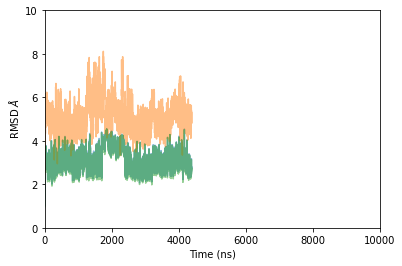

In [39]:
# Lets do time evolution of RMSD


df_rms.full.plot( alpha=0.5)
df_rms.peptide.plot( alpha=0.5)
df_rms.receptor.plot( alpha=0.5)
plt.xlim( [0,10000])
plt.ylim( [0,10])
plt.xlabel('Time (ns)')
plt.ylabel( ' RMSD $\AA$')


(0.0, 15.0)

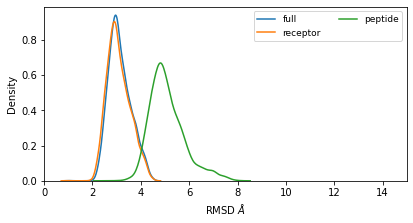

In [40]:
# Lets see the distribution of RMSD values
fig, ax = plt.subplots( figsize=(6.5,3.2) )
sns.distplot(df_rms.full,hist=False,label='full',ax=ax)
sns.distplot(df_rms.receptor,hist=False,label='receptor',ax=ax)
sns.distplot(df_rms.peptide,hist=False,label='peptide',ax=ax)

plt.legend(ncol=2,fontsize=9)
plt.xlabel('RMSD $\AA$')
plt.xlim( [0,15])

#### **RMSF**

<AxesSubplot:>

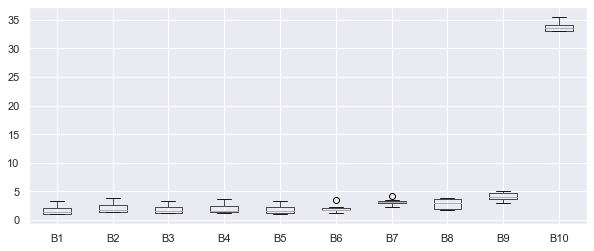

In [378]:
df_rmsf.boxplot() 

Text(0, 0.5, 'RMSF $\\AA$')

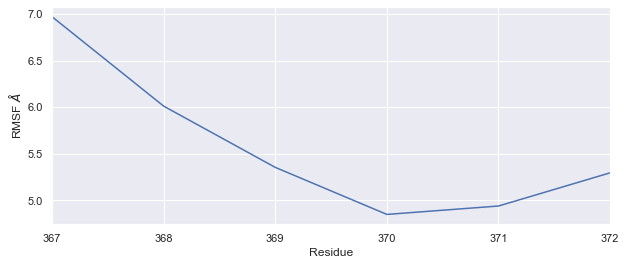

In [379]:
rmsf_m1 = df_rmsf.loc[ : , 'B1':'B10'].mean(axis=1)
#rmsf_m2 = df_rmsf.loc[ : , 'B4':'B7'].mean(axis=1)
#rmsf_m3 = df_rmsf.loc[ : , 'B7':'B10'].mean(axis=1)

rmsf_m1.plot()
#rmsf_m2.plot()
#rmsf_m3.plot()

plt.xlim([367,372])
# Highlight NBD
#plt.axvspan(40,155,color='k',alpha=0.2)
#plt.axvspan(157,265,color='g',alpha=0.1)
#plt.axvspan(267,375,color='y',alpha=0.1)
#plt.axvspan(342,373,color='R',alpha=0.1)

#plt.text(80,15,'D1',size=16)
#plt.text(200,15,'D2',size=16)
#plt.text(300,15,'D3',size=16)
#plt.text(315,15,'D4',size=16)
plt.ylabel('RMSF $\AA$')

#### **PCA**

Text(0.5, 0, 'PC index')

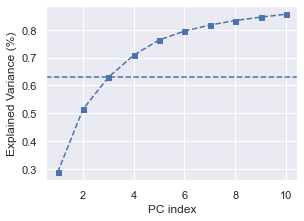

In [380]:
# Visualize cumulative variance of first 10 PCs
fig, ax = plt.subplots( figsize=(4.5,3.2) )
Y = mypca.cumulated_variance[:10]
X = [ l+1 for l in range(10) ]
ax.plot( X, Y ,'s--' ,ms=5)
ax.axhline( Y[2], color='b' , ls='--' )
ax.set_ylabel('Explained Variance (%)')
ax.set_xlabel('PC index')

<AxesSubplot:xlabel='PC1', ylabel='PC3'>

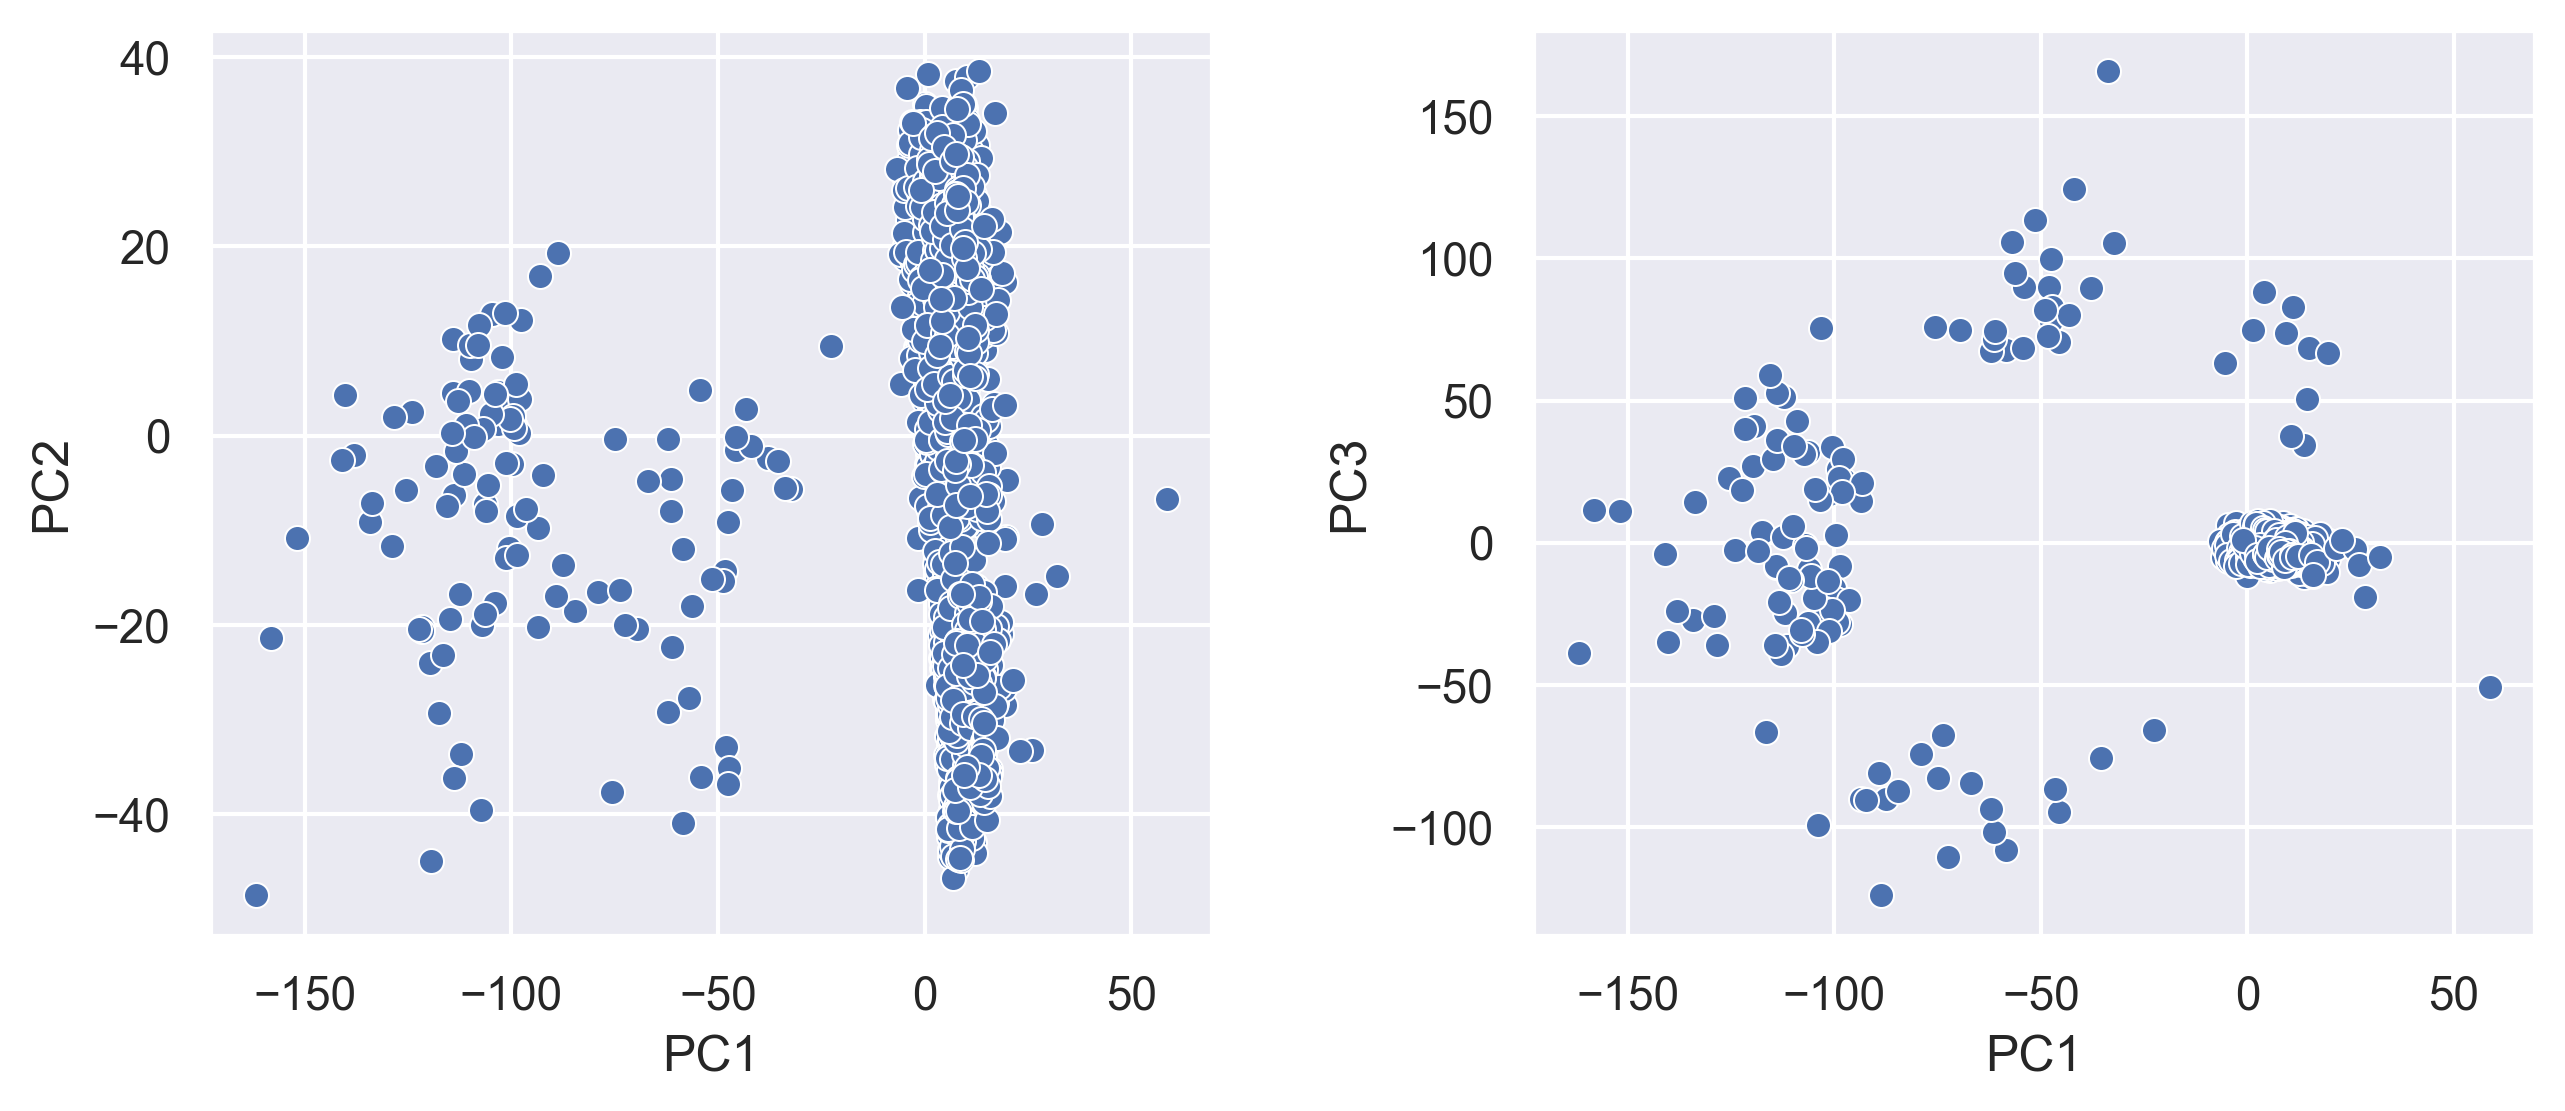

In [381]:
# We visualize the scatter plots for most prominent (PC1-3)
# Make scatter plots of PCs1-3
fig, ax = plt.subplots(1,2,figsize=(10,4),dpi=300 )
fig.subplots_adjust( wspace = 0.32)

sns.scatterplot(data=df_pca,x="PC1",y="PC2",ax=ax[0])
sns.scatterplot(data=df_pca,x="PC1",y="PC3",ax=ax[1])


# Seaborn color maps (https://seaborn.pydata.org/tutorial/color_palettes.html)

#sns.kdeplot(data=df_pca,x="PC1",y="PC2",ax=ax[0],shade=True,cmap='Greys_r')
#sns.kdeplot(data=df_pca,x="PC1",y="PC3",ax=ax[1],shade=True,cmap='Set1')


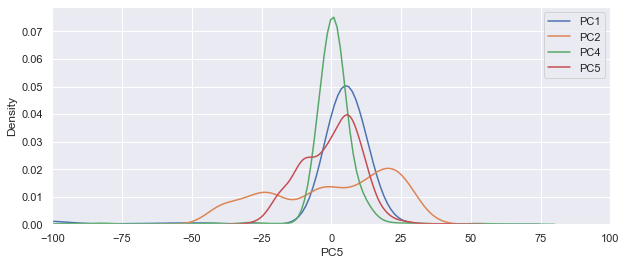

In [382]:
# Distribution along individual PC components
sns.distplot(df_pca.PC1,label='PC1',hist=False)
sns.distplot(df_pca.PC2,label='PC2',hist=False)
sns.distplot(df_pca.PC4,label='PC4',hist=False)
sns.distplot(df_pca.PC5,label='PC5',hist=False)

plt.legend()  #Explained Variance reduces as we go from PC1 to PC5
plt.xlim([-100,100])
sns.set(rc={'figure.figsize':(10,4)})

#### **Cluster Evolution**


Text(0, 0.5, 'RMSD $\\AA$')

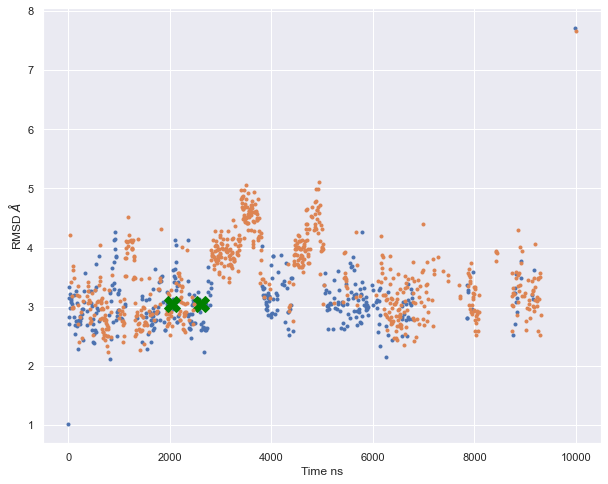

In [388]:
# Lets map clusters on RMSD plot
nclus = set( df_clus.Cluster)
fig, ax = plt.subplots( figsize=(10,8) )

for val in nclus:
    # val -1 indicates noise points
    # For each cluster, we show frame closer to cluster centroid as Cross
    if val > -1:
        data = df_clus[ df_clus.Cluster == val ]
        ax.plot( data.index,data.RMSD,'.')
        
        Mn = data.CDist.min()
        Cent =  data[ data.CDist == Mn ]
        ax.plot( Cent.index, Cent.RMSD, 'X',color='green',ms=16)
            

ax.set_xlabel('Time ns')
ax.set_ylabel('RMSD $\AA$')

In [69]:
# Lets view the Cluster representatives
r1 = mda.Universe( 'C1.pdb' )
r2 = mda.Universe( 'C2.pdb' )
#r3 = mda.Universe( 'C3.pdb' )

view = nv.show_mdanalysis(r1)
view.add_trajectory( r2 )
#view.add_trajectory( r3 )

view[0].clear_representations()
view[0].add_cartoon(color='blue')
view[1].clear_representations()
view[1].add_cartoon(color='yellow')


#view[2].clear_representations()
#view[2].add_cartoon(color='cyan')

#view.display(gui=True)
#show_residues_around(view,selection="367",radius=4.0)
view

NGLWidget()

#### **Inference:**